In [1]:
import sys
sys.path.append("..")

In [2]:
from collections import Counter
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mlresearch.utils import set_matplotlib_style
from recgame.environments import BaseEnvironment
from functions import (
    fairness_metrics_viz_data, 
    biased_data_generator_hc, 
    get_scaler_hc, 
    fairness_metrics_overall, 
    fairness_metrics_overall_visualizations, 
    fairness_metrics_per_time_step, 
    fairness_metrics_viz_data,
    IgnoreGroupRanker,
    IgnoreGroupLR
)
from equalizing_recourse_across_groups import run_agnostic
import seaborn as sns
import matplotlib.pyplot as plt

set_matplotlib_style(16)

# Some variables to define the problem
BIAS_FACTOR = 1
RNG_SEED = 55
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_AGENTS = 100

# NOTE: Categorical feature will be the "groups" variable; immutable + categorical

# Environment variables
N_LOANS = 25
ADAPTATION = .5
NEW_AGENTS = 35

# NFeatureRecourse ignoring categorical feature

In [3]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse


class NFeatureRecourse(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual


# Define functions

In [4]:
def env_biased_data_generator(n_agents):
    return biased_data_generator_hc(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_LOANS=N_LOANS, N_AGENTS=N_AGENTS)

In [5]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

# Experiments (Standard Environment)

In [6]:
scaler = get_scaler_hc(
    n_agents=10_000, 
    bias_factor=BIAS_FACTOR, 
    random_state=rng,
    N_AGENTS=N_AGENTS, 
    N_LOANS=N_LOANS
)

In [7]:
df = biased_data_generator_hc(N_AGENTS, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_LOANS=N_LOANS, N_AGENTS=N_AGENTS)
categorical = ["groups"]

model = IgnoreGroupRanker(np.array([[.5, .5]]), ignore_feature=categorical)

In [8]:
# y = model.predict_proba(df)[:, -1]
# threshold = np.sort(y)[-N_LOANS]
# y = pd.Series((y >= threshold).astype(int), index=df.index)
y = pd.Series(model.predict(df), index=df.index)

new_model = run_agnostic(
    df,
    y,
    classifier=LogisticRegression(penalty="l2", fit_intercept=True, random_state=RNG_SEED),
    sed=RNG_SEED,
)

# We are applying coefficients to the model object because 
new_coef_ = deepcopy(new_model.coef_)
new_intercept_ = deepcopy(new_model.intercept_)
trained_model = IgnoreGroupLR(ignore_feature=categorical, random_state=RNG_SEED).fit(df, y)
new_model = IgnoreGroupLR(ignore_feature=categorical, random_state=RNG_SEED).fit(df, y)
new_model.coef_ = new_coef_
new_model.intercept_ = new_intercept_

In [9]:
# y.values
# df_tmp = pd.concat([df, y], axis=1)
# df_tmp["score"] = df[["f0", "f1"]].mean(axis=1)
# df_tmp

In [10]:
# model_tmp = LogisticRegression(penalty="l2").fit(df.drop(columns="groups"), y)
# print(model_tmp.score(df.drop(columns="groups"), y))
# model_tmp.coef_, model_tmp.intercept_

Text(0.5, 1.0, 'Ranker')

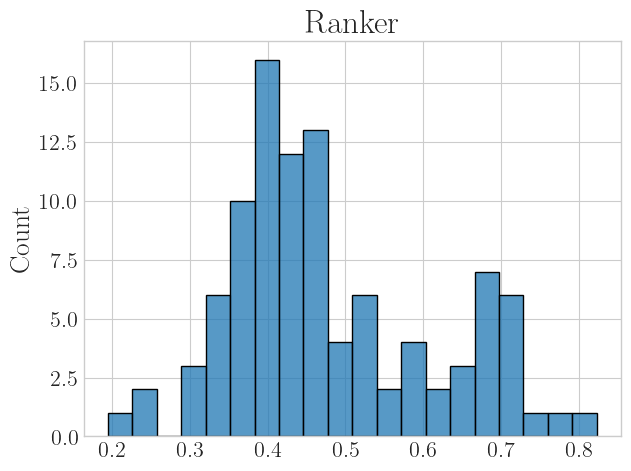

In [11]:
ax = sns.histplot(model.predict_proba(df)[:,0],bins=20)
ax.set_title("Ranker")

Text(0.5, 1.0, 'Model with coefficients learning')

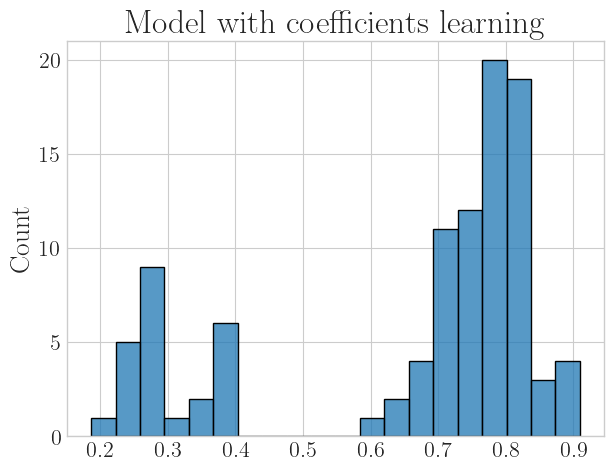

In [12]:
ax = sns.histplot(trained_model.predict_proba(df)[:,0],bins=20)
ax.set_title("Model with coefficients learning")

Text(0.5, 1.0, 'Regularized model')

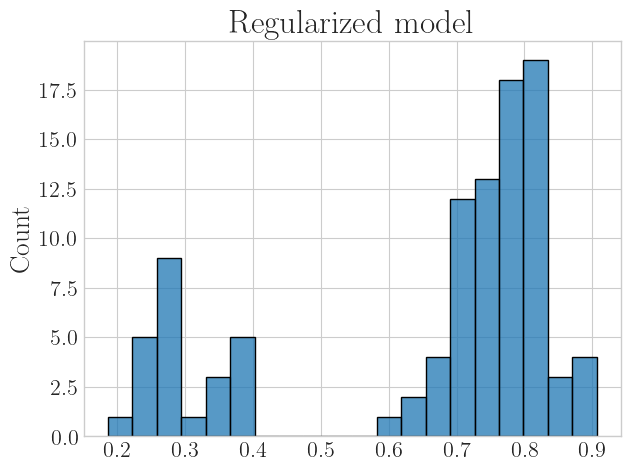

In [13]:
ax = sns.histplot(new_model.predict_proba(df)[:,0],bins=20)
ax.set_title("Regularized model")

Original classes:
 groups   
0.0     0    33
        1    17
1.0     0    33
        1    17
dtype: int64
Predicted classes:
 groups   
0.0     0    38
        1    12
1.0     0    38
        1    12
dtype: int64


<Axes: title={'center': 'f1'}, ylabel='Frequency'>

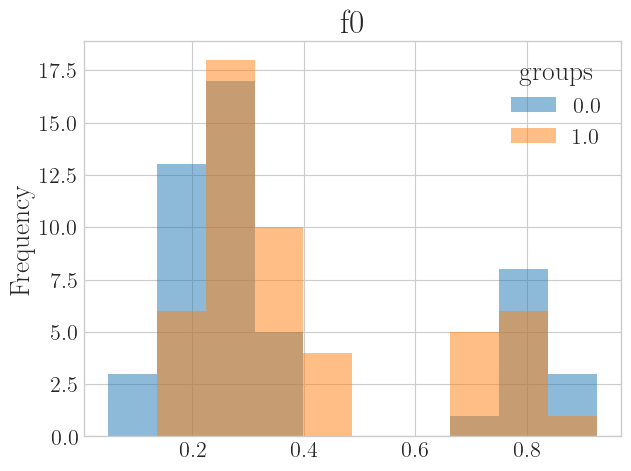

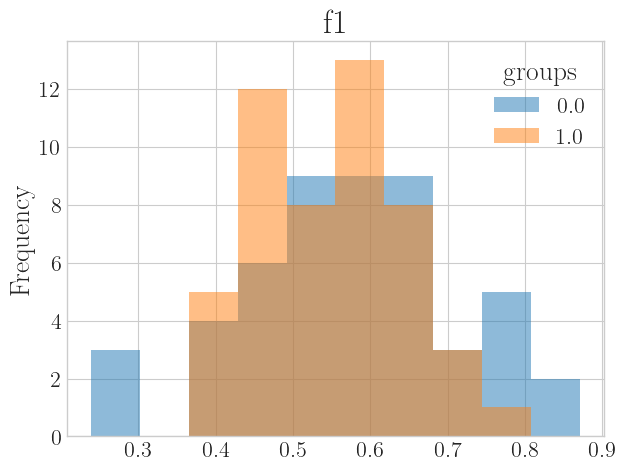

In [14]:
print("Original classes:\n", df.groupby(["groups", y]).size())
print("Predicted classes:\n", df.groupby(["groups", new_model.predict(df)]).size())
df.pivot(columns="groups")["f0"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f0")
df.pivot(columns="groups")["f1"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f1")

In [15]:
df.min(), df.max()

(f0        0.048354
 f1        0.239123
 groups    0.000000
 dtype: float64,
 f0        0.925864
 f1        0.870959
 groups    1.000000
 dtype: float64)

In [16]:
# Define the necessary components to run simulation
recourse = NFeatureRecourse(new_model, categorical=["groups"], immutable=["groups"])# , random_state=RNG_SEED)
recourse.set_actions(df)
recourse.action_set_.lb = [-0.1, -0.1, 0]
recourse.action_set_.ub = [1.1, 1.1, 1]

environment = BaseEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

BaseEnvironment(X=          f0        f1  groups
0   0.813615  0.550460     1.0
1   0.882357  0.763333     1.0
2   0.728015  0.618395     1.0
3   0.781051  0.385422     1.0
4   0.822176  0.560455     1.0
..       ...       ...     ...
95  0.048354  0.665953     0.0
96  0.290867  0.781994     0.0
97  0.222279  0.695138     0.0
98  0.211582  0.572285     0.0
99  0.223260  0.541247     0.0

[100 rows x 3 columns],
                adaptation=0.5, behavior_function='continuous_constant',
                data_source_func=<function env_biased_data_generator at 0x7f5652c441f0>,
                growth_rate=35, growth_rate_type='absolute', random_state=55,
                recourse=NFeatureRecourse(categorical=['groups'],
                                          immutable=['groups'],
                                          model=IgnoreGroupLR(ignore_feature=['groups']),
                                          threshold=0.6278382228709389),
                threshold=25)

# Visualization and analysis (Standard Environment)

In [17]:
from matplotlib.colors import ListedColormap
environment.plot._favorable = ListedColormap(["#40b27f", "green"])
environment.plot._unfavorable = ListedColormap(["#51a3ef", "blue"])
environment.plot._previous = ListedColormap(["#be4d65", "red"])

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

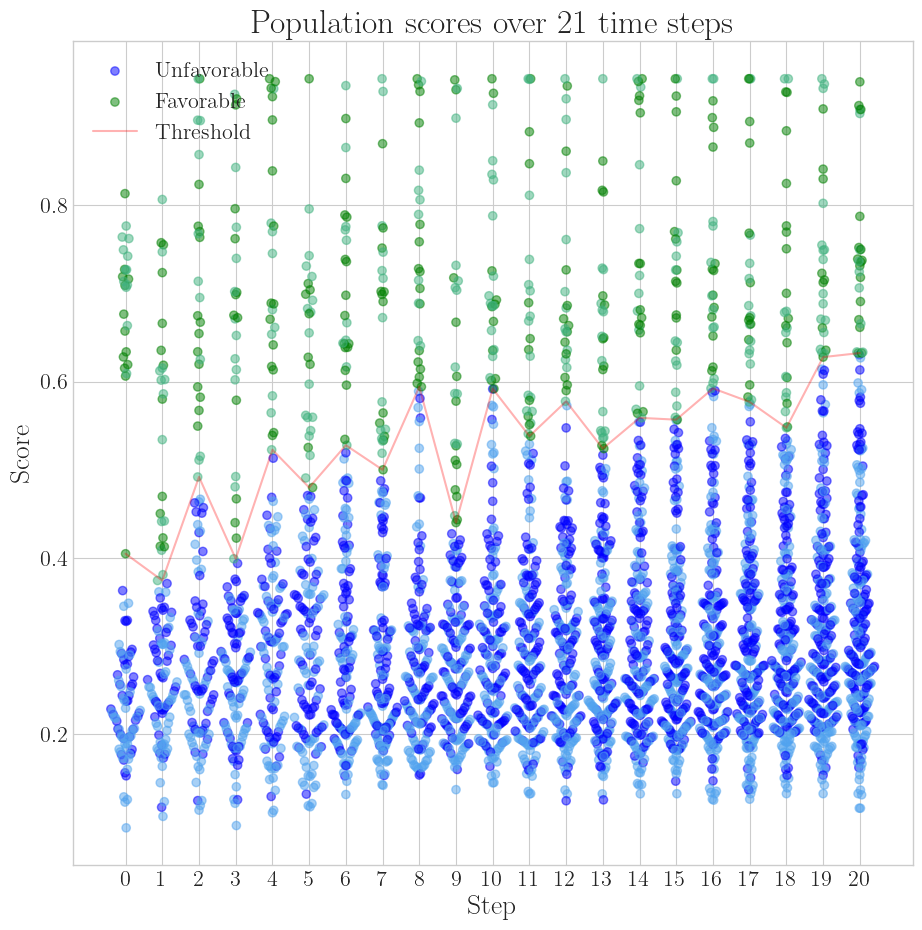

In [18]:
environment.plot.agent_scores(color_feature="groups")

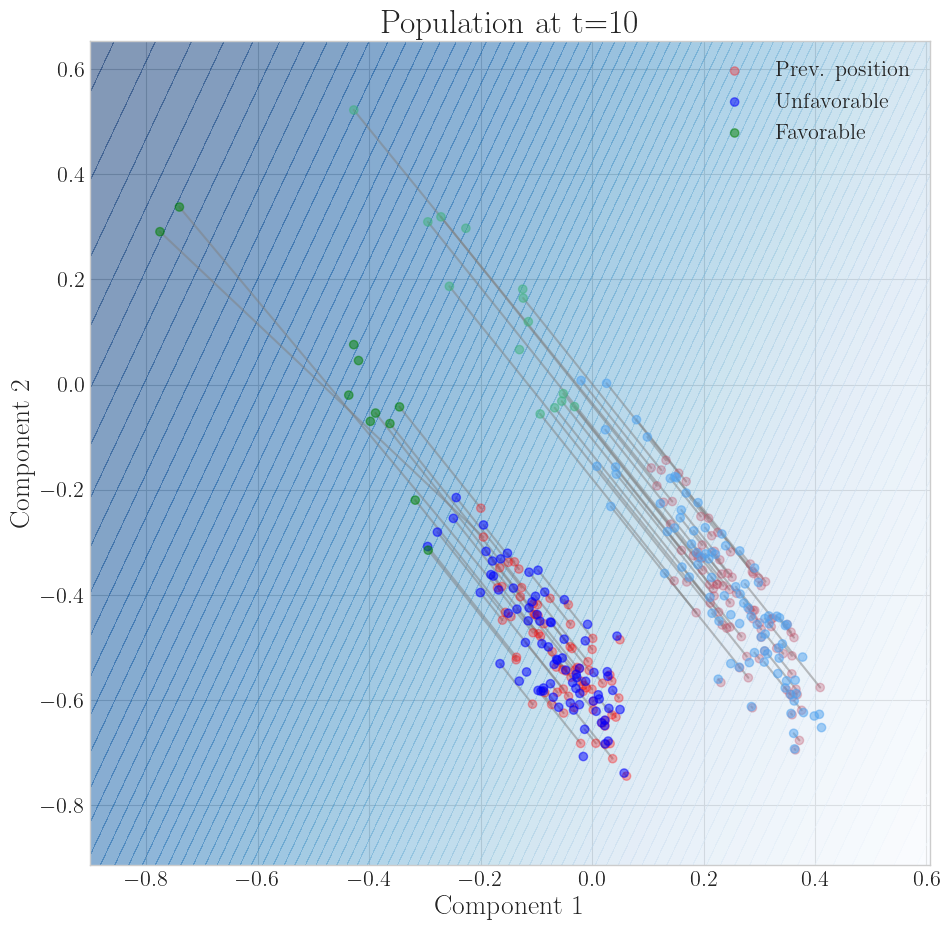

In [19]:
ax = environment.plot.scatter(10, color_feature="groups")

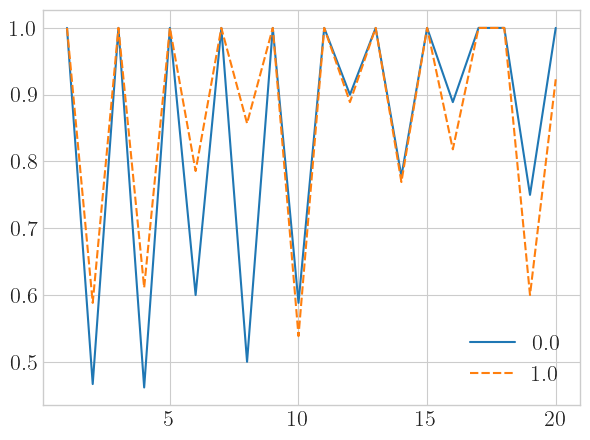

In [20]:
fairness_metrics_per_time_step(environment)

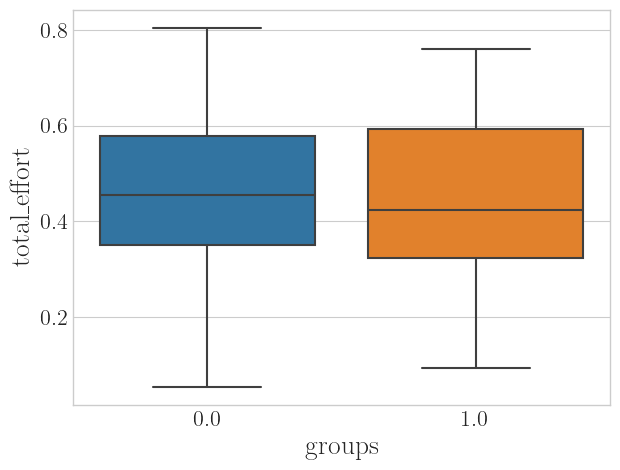

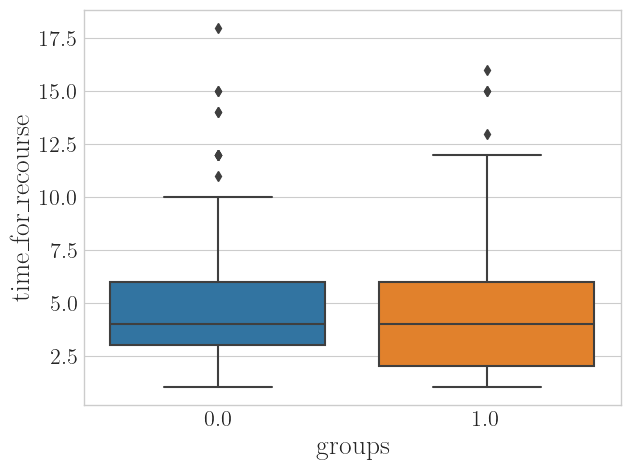

{'etr_disparity': 1.0374282825076775, 'disparate_ttr': 0.6061497326203211}

In [21]:
fairness_metrics_overall_visualizations(environment)
# Boxplots for different qualification values

In [22]:
fairness_metrics_viz_data(environment)

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures,groups,time_for_recourse,total_effort
13,0,3,3.0,0.278403,0.422356,1,1.0,3.0,0.143953
15,0,3,3.0,0.214521,0.914143,1,1.0,3.0,0.699622
16,0,1,1.0,0.296022,0.469696,0,1.0,1.0,0.173674
17,0,1,1.0,0.287728,0.635488,0,1.0,1.0,0.347760
18,0,2,2.0,0.243542,0.823885,0,1.0,2.0,0.580343
...,...,...,...,...,...,...,...,...,...
626,16,4,20.0,0.270195,0.913356,0,1.0,4.0,0.643162
639,16,4,20.0,0.241907,0.749538,0,0.0,4.0,0.507631
656,17,3,20.0,0.307065,0.632463,0,1.0,3.0,0.325399
679,18,1,19.0,0.535532,0.841251,0,1.0,1.0,0.305719


# Draft code

In [23]:
environment.analysis.agents_info().favorable_step.min()

0.0

In [24]:
df_fair_grouped = df_fair.groupby(["groups", "effort_bins"]).mean()
df_fair_grouped["size"] = df_fair.groupby(["groups", "effort_bins"]).size()
# df_fair_grouped.loc[1]
# df_fair_grouped.loc[0]
df_fair_grouped

NameError: name 'df_fair' is not defined

In [ ]:
environment.metadata_[5]["threshold_index"]
environment.metadata_[5]["effort"]

In [ ]:
df

In [ ]:
counts = Counter(df["groups"])

In [ ]:
Counter(environment.X_.groups)

In [ ]:
Counter(environment.get_all_agents().groups)